In [187]:
import pickle
from gensim.models import doc2vec
import numpy as np
import time 
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from collections import defaultdict
from sklearn.metrics import fowlkes_mallows_score
from hdbscan import HDBSCAN

In [21]:
# corpus is compressed now
vocab = pickle.load(open('data/compressed_vocab.pickle', 'rb'))
pos2vocab = dict([(i[1], i[0]) for i in vocab.items()])
len(vocab)

222895

In [22]:
multiple_sig = pickle.load(open('data/multiple_sig_last_year.pickle', 'rb'))
prepared = [sig['prepared'] for sig in multiple_sig]
len(multiple_sig)

261

In [15]:
# multiple_sig[0]

In [9]:
# see BugzillaDownloader.ipynb for calculation details

In [53]:
ccc  = lambda a,b:1
ccc (1,2), ccc('a', 'b')

(1, 1)

In [111]:
def edit_distance2(s1, s2, ins_cost=lambda a,b:1, del_cost=lambda a,b:1, subst_cost=lambda a,b:1):
    if len(s1) < len(s2):
        return edit_distance(s2, s1, ins_cost, del_cost, subst_cost)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + ins_cost(s1[i], s2[j]) # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + del_cost(s2[j], s2[j-1])      # than s2
            substitutions = previous_row[j] + (c1 != c2) * subst_cost(c1, c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [23]:
def labels_to_clusters(labels):
    clusters = defaultdict(list)
    for i, c in enumerate(labels):
        if c != -1:
            clusters[c].append(i)
    return clusters

In [24]:
def predicted_for_group(group, predicted):
    rv = defaultdict(int)
    for g in group:
        for c, points in predicted.items():
            if g in points:
                rv[c] += 1
    return rv

def calc_accuracy(predicted, true):
    total = sum([len(i) for i in predicted.values()])     
    good = sum([max(predicted_for_group(g, predicted).values() or [0]) for g in true])
    return good / float(total)

In [135]:
def calc_score(predicted, true):
    total = sum([len(i) for i in predicted.values()])
    err = sum([len(g) - max(predicted_for_group(g, predicted).values() or [0]) for g in true])
    return 1 - err/ float(total)

In [26]:
groups = []
corpus = []
for p in prepared:
    group = []
    for t in p:
        corpus.append(t)
        group.append(len(corpus)-1)
    groups.append(group)
compressed_corpus = [[str(vocab.get(i, i)) for i in c] for c in corpus]
compressed_corpus = [doc2vec.TaggedDocument(trace, [i]) for i, trace in enumerate(compressed_corpus)]
groups = [g for g in groups if len(g) > 1]

In [27]:
len(compressed_corpus)

755

In [19]:
edit_dist_no_coff = pickle.load(open('data/edit_dist_no_coff_last_year.pickle', 'rb'))
edit_dist_no_coff.shape

(755, 755)

In [20]:
edit_dist_coff = pickle.load(open('data/edit_dist_coff_last_year.pickle', 'rb'))
edit_dist_coff.shape

(755, 755)

In [209]:
wmd_all = pickle.load(open('data/wmd_last_year.pickle', 'rb'))
wmd_all[wmd_all == np.inf] = -1
m = np.max(wmd_all)
wmd_all[wmd_all == -1] = m
wmd_all.shape

(755, 755)

In [22]:
np.mean(edit_dist_coff)

36.08441384122623

In [23]:
np.mean(edit_dist_no_coff)

30.378516731722293

In [24]:
np.mean(wmd_all)

1.2975248343326107

In [120]:
def dbscan(dist, eps=0.5, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dist)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return labels, n_clusters, core_samples_mask

In [26]:
def hdbscan(dist, min_samples=5):
    hdb = HDBSCAN(eps = 0.5, min_samples=min_samples, metric='precomputed').fit(dist)
    labels = hdb.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return labels, n_clusters

In [121]:
def plot_clusters(labels, n_clusters, core_samples_mask, dist, remove_outliers=True):
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            if remove_outliers:
                continue
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = dist[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=8)

        xy = dist[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=4)

    plt.title('Estimated number of clusters: %d' % n_clusters)
    plt.show()

In [210]:
labels, n_clusters, core_samples_mask = dbscan(wmd_all, min_samples=2)
n_clusters

117

In [29]:
hlabels, hn_clusters = hdbscan(wmd_all, min_samples=1)
hn_clusters

49

In [30]:
hclusters_wmd = labels_to_clusters(hlabels)
len(hclusters_wmd), np.mean([len(i) for i in hclusters_wmd.values()])

(49, 8.6326530612244898)

In [64]:
true_labels = [-1] * len(compressed_corpus)
for i, g in enumerate(groups):
    for x in g:
        true_labels[x] = i

In [69]:
fowlkes_mallows_score(true_labels, labels_nec)

0.089596260546777981

In [72]:
calc_score(clusters_wmd, groups)

0.306930693069307

In [41]:
calc_accuracy(hclusters_wmd, groups)

(0.8014184397163121, 0.40710726742116876)

In [ ]:
fowlkes_mallows_score()

In [42]:
clusters_wmd = labels_to_clusters(labels)
len(clusters_wmd), np.mean([len(i) for i in clusters_wmd.values()])

(117, 4.316239316239316)

In [43]:
calc_accuracy(clusters_wmd, groups)

(0.7524752475247525, 0.50839561534628797)

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


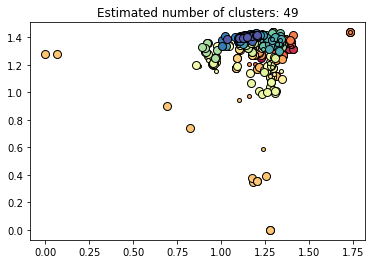

In [44]:
plot_clusters(hlabels, hn_clusters, core_samples_mask, wmd_all)

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


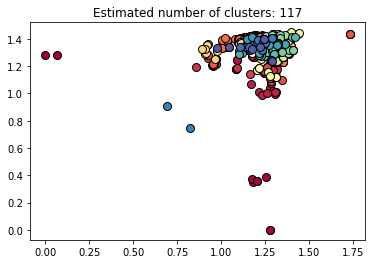

In [211]:
plot_clusters(labels, n_clusters, core_samples_mask, wmd_all)

In [45]:
labels_ec, n_clusters_ec, core_samples_mask_ec = dbscan(edit_dist_coff, eps=5, min_samples=2)
n_clusters_ec

106

In [46]:
calc_accuracy(labels_to_clusters(labels_ec), groups)

(0.7627118644067796, 0.41391202220798634)

In [73]:
calc_score(labels_to_clusters(labels_ec), groups)

-0.004842615012106588

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


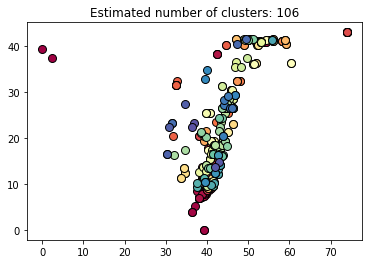

In [155]:
plot_clusters(labels_ec, n_clusters_ec, core_samples_mask_ec, edit_dist_coff)

In [47]:
labels_nec, n_clusters_nec, core_samples_mask_nec = dbscan(edit_dist_no_coff, eps=5, min_samples=2)
n_clusters_nec

105

In [48]:
calc_accuracy(labels_to_clusters(labels_nec), groups)

(0.7505938242280285, 0.42162787387002637)

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


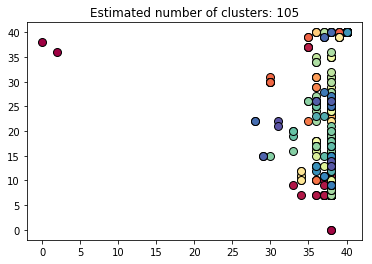

In [157]:
plot_clusters(labels_nec, n_clusters_nec, core_samples_mask_nec, edit_dist_no_coff)

In [55]:
def struct_dist_calc(s1, s2):
    if len(s1) < len(s2):
        return struct_dist_calc(s2, s1)
    s2 += [''] * (len(s1)-len(s2))
    return sum([struct_word_dist(i[0], i[1]) for i in zip(s1, s2)])

In [112]:
def struct_word_dist(w1, w2):
    parts1 = w1.split('::')
    parts2 = w2.split('::')
    if len(parts1) < len(parts2):
        return struct_word_dist(w2, w1)
    prefix = 0
    i = 0
    while i < len(parts2) and i < len(parts1) and parts1[i] == parts2[i]:
        prefix += 1
        i += 1
    return 1 - float(prefix) / max(len(parts1), len(parts2))

In [113]:
struct_word_dist('a::b::c','a::b::c::d')

0.25

In [114]:
def edit_distance_matrix(corpus, calculator, prog=10):
    dist = np.zeros((len(corpus), len(corpus)), dtype=np.double)
    idx = []
    for i in range(len(corpus)):
        for j in range(i+1, len(corpus)):
            idx.append((i, j))
    say = len(idx) // prog
    t = time.time()
    for s, (i, j) in enumerate(idx):
        if s and s % say == 0:
            print('{}%, {} s.'.format(s / (len(idx) * 0.01), time.time() - t))
        doc1 = corpus[i].words
        doc2 = corpus[j].words
        dist[i, j] = dist[j, i] = calculator(doc1, doc2)
    return dist

In [115]:
class Tmp(object):
    def __init__(self, words):
        self.words = words

In [116]:
def struct_dist_calc(s1, s2):
    return edit_distance2(s1, s2, subst_cost=struct_word_dist)

In [118]:
struct_dist = edit_distance_matrix([Tmp(i) for i in corpus], struct_dist_calc)

9.999824336430867%, 71.65830969810486 s.
19.999648672861735%, 128.64697909355164 s.
29.999473009292604%, 201.19729733467102 s.
39.99929734572347%, 262.8518741130829 s.
49.99912168215434%, 327.5255489349365 s.
59.99894601858521%, 381.7634754180908 s.
69.99877035501608%, 437.0748143196106 s.
79.99859469144694%, 499.5568869113922 s.
89.99841902787782%, 556.2634818553925 s.
99.99824336430868%, 610.9814057350159 s.


In [168]:
labels_struct, n_clusters_struct, core_samples_mask_struct = dbscan(struct_dist, eps=5, min_samples=2)
n_clusters_struct

104

In [169]:
pred = list(labels_to_clusters(labels_struct).values())

In [164]:
def dist_for_cluster(cluster, dist):
    rv = np.zeros((len(cluster), len(cluster)), dtype=np.double)
    for i, c in enumerate(cluster):
        for j, v in enumerate(cluster):
            rv[i, j] = dist[c, v]
    return rv

In [188]:
ms = MeanShift(cluster_all=False).fit(struct_dist)
labels = ms.labels_

In [212]:
mmmax = [np.max(dist_for_cluster(g, wmd_all)) for g in groups]
mmavg = [np.average(dist_for_cluster(g, wmd_all)) for g in groups]

In [213]:
mmmax[-15:]

[0.0,
 0.16455364557773777,
 1.3560466011923007,
 0.74215119642462224,
 0.73337774053998306,
 0.470341660650063,
 0.53204466448187315,
 0.68987251849196596,
 1.0509877710226843,
 1.0653374075384652,
 0.59927020150559041,
 1.3429966131368156,
 0.19567003976082228,
 0.92297023095527875,
 0.55120213581418342]

In [214]:
mmavg[-15:]

[0.0,
 0.082276822788868886,
 0.67802330059615035,
 0.37107559821231112,
 0.36668887026999153,
 0.2351708303250315,
 0.26602233224093658,
 0.34493625924598298,
 0.52549388551134213,
 0.53266870376923259,
 0.2996351007527952,
 0.67149830656840781,
 0.097835019880411142,
 0.46148511547763937,
 0.27560106790709171]

In [197]:
np.max(dist_for_cluster(groups[42], struct_dist))

32.5

In [192]:
groups[42]

[307, 308, 309, 310]

In [195]:
corpus[308]

['d3d10warp.dll@0x',
 'd3d11.dll@0x',
 'd3d11.dll@0x',
 'd3d11.dll@0x',
 'mozilla::layers::syncobjectd3d11::finalizeframe',
 'mozilla::layers::clientlayermanager::forwardtransaction',
 'mozilla::layers::clientlayermanager::endtransaction',
 'nsdisplaylist::paintroot',
 'nslayoututils::paintframe',
 'presshell::paint']

In [194]:
corpus[307]

['d3d10warp.dll@0x',
 'd3d10warp.dll@0x',
 'd3d11.dll@0x',
 'mozilla::layers::compositord3d11::drawquad',
 'mozilla::layers::imagehost::composite',
 '<t>::operator()',
 'mozilla::layers::renderwithallmasks<t>',
 'mozilla::layers::renderlayers<t>',
 '_md_current_thread']

In [179]:
corpus[8]

['js::wasm::deserializepodvector<t>',
 'js::wasm::module::deserialize',
 'lookupasmjsmoduleincache',
 'js::compileasmjs',
 'js::frontend::parser<t>::asmjs']

In [184]:
struct_dist[121, 9]

6.3333333333333339

In [182]:
corpus[9]

['memcpy',
 'js::wasm::deserializepodvector<t>',
 'js::wasm::metadata::deserialize',
 'js::asmjsmetadata::deserialize',
 'js::wasm::module::deserialize',
 'lookupasmjsmoduleincache',
 'js::compileasmjs',
 'js::frontend::parser<t>::asmjs']

In [180]:
corpus[121]

['js::jit::backtrackingallocator::buildlivenessinfo',
 'js::jit::backtrackingallocator::go',
 'js::jit::generatelir',
 'js::jit::compilebackend',
 'js::helperthread::handleionworkload',
 'js::helperthread::threadloop']

In [186]:
np.max(dist_for_cluster(pred[4], struct_dist))

11.0

In [178]:
pred[4][:10]

[8, 9, 37, 40, 41, 96, 113, 114, 116, 121]

In [146]:
calc_accuracy(labels_to_clusters(labels_struct), groups)

0.6556291390728477

In [147]:
calc_score(labels_to_clusters(labels_struct), groups)

0.6887417218543046

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


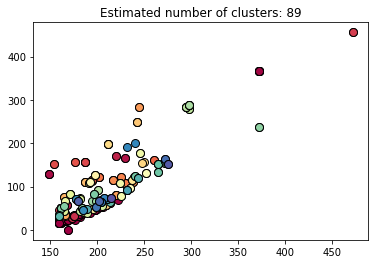

In [62]:
plot_clusters(labels_struct, n_clusters_struct, core_samples_mask_struct, struct_dist)

In [28]:
def traces_in_cluster(cluster):
    return [corpus[i] for i in cluster]

In [ ]:
def distances_in_cluster(cluster, dist):
    rv = np.zeros((len(cluster), len(cluster)), dtype=np.double)
    return rv